# Model Training: Linear Regression, Random Forest, XGBoost
## Stanford TECH 27 Final Project - Notebook 06

This notebook trains and compares three regression models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import warnings
import pickle
from pathlib import Path

warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Processed Data

Load the final processed datasets from notebook 05.

In [2]:
# Load processed data from notebook 05_final_processing.ipynb
OUTPUT_DIR = Path('processed_data')
ml_datasets_path = OUTPUT_DIR / 'final_ml_ml_datasets.pkl'

if ml_datasets_path.exists():
    print(f"Loading processed datasets from {ml_datasets_path}...")
    with open(ml_datasets_path, 'rb') as f:
        ml_datasets = pickle.load(f)
    
    # Extract the full datasets
    X_train_full = ml_datasets['X_train']
    X_val_full = ml_datasets['X_val']
    X_test_full = ml_datasets['X_test']
    y_train = ml_datasets['y_train']
    y_val = ml_datasets['y_val']
    y_test = ml_datasets['y_test']
    
    # Get all feature names
    all_feature_cols = ml_datasets.get('feature_cols', 
                                       [f'feature_{i}' for i in range(X_train_full.shape[1])])
    
    print(f"✅ Successfully loaded datasets from notebook 5")
    print(f"Full dataset: {X_train_full.shape[0]} training samples, {X_train_full.shape[1]} features")
    print(f"\nAll available features ({len(all_feature_cols)}):")
    for i, feat in enumerate(all_feature_cols, 1):
        print(f"{i:3d}. {feat}")
    
else:
    print(f"❌ Error: Could not find {ml_datasets_path}")
    print("Please run notebook 05_final_processing.ipynb first to generate the datasets.")
    raise FileNotFoundError(f"Dataset file not found: {ml_datasets_path}")

Loading processed datasets from processed_data/final_ml_ml_datasets.pkl...
✅ Successfully loaded datasets from notebook 5
Full dataset: 326540 training samples, 45 features

All available features (45):
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 11. current_change
 12. temperature_change
 13. power_change
 14. voltage_rolling_mean_5
 15. current_rolling_mean_5
 16. temperature_rolling_mean_5
 17. voltage_rolling_std_5
 18. current_rolling_std_5
 19. voltage_rolling_mean_10
 20. current_rolling_mean_10
 21. temperature_rolling_mean_10
 22. voltage_rolling_std_10
 23. current_rolling_std_10
 24. voltage_rolling_mean_20
 25. current_rolling_mean_20
 26. temperature_rolling_mean_20
 27. voltage_rolling_std_20
 28. current_rolling_std_20
 29. cumulative_discharge
 30. cumulative_energy
 31. time_normalized
 32. time_since_start
 33. voltage_lag_1
 34. current_lag_1
 35

## 2. Filter Features 

Filter the dataset to use only the specified realistic features that would be available from V, I, T measurements. Specifically exclude the SOC lag features we created (predicting SOC from what SOC was 2 seconds ago is too easy).

In [3]:
# Define the specific features to use
features = [
    # Direct measurements
    'voltage', 'current', 'temperature',
    'Current_load', 'Voltage_load',  # If we have load measurements
    
    # Physics-based calculations from V&I
    'power',  # V * I
    'abs_current',  # |I|
    'voltage_current_ratio',  # V/I (related to resistance)
    'energy',  # Cumulative V*I*dt
    
    # Time derivatives and changes
    'voltage_change',  # dV/dt
    'current_change',  # dI/dt
    'power_change',  # dP/dt
    'temperature_change',  # dT/dt
    
    # Rolling statistics
    'voltage_rolling_mean_5', 'voltage_rolling_mean_10',
    'voltage_rolling_std_5', 'voltage_rolling_std_10',
    'current_rolling_mean_5', 'current_rolling_mean_10',
    'current_rolling_std_5', 'current_rolling_std_10',
    
    # Lagged features
    'voltage_lag_1',
    'current_lag_1',
    
    # Cumulative features (coulomb counting)
    'cumulative_energy',  # ∫P dt
]

# Find which features from our list are actually available in the dataset
available_realistic = [f for f in features if f in all_feature_cols]
missing_features = [f for f in features if f not in all_feature_cols]

# Identify features being excluded (especially SOC-related ones)
excluded_features = [f for f in all_feature_cols if f not in available_realistic]

print(f"\n📊 Feature Selection Summary:")
print(f"   Total features in dataset: {len(all_feature_cols)}")
print(f"   Realistic features requested: {len(features)}")
print(f"   Realistic features available: {len(available_realistic)}")
print(f"   Features being excluded: {len(excluded_features)}")

if missing_features:
    print(f"\n⚠️  Missing features (not in dataset):")
    for feat in missing_features:
        print(f"   - {feat}")

print(f"\n🚫 Excluded features ({len(excluded_features)}):")
soc_excluded = [f for f in excluded_features if 'SOC' in f]
other_excluded = [f for f in excluded_features if 'SOC' not in f]

if soc_excluded:
    print(f"   SOC-related features ({len(soc_excluded)}):")
    for feat in soc_excluded:
        print(f"      - {feat}")

if other_excluded:
    print(f"   Other features ({len(other_excluded)}):")
    for feat in other_excluded:
        print(f"      - {feat}")

print(f"\n✅ Using {len(available_realistic)} realistic features:")
for i, feat in enumerate(available_realistic, 1):
    print(f"{i:3d}. {feat}")


📊 Feature Selection Summary:
   Total features in dataset: 45
   Realistic features requested: 24
   Realistic features available: 24
   Features being excluded: 21

🚫 Excluded features (21):
   SOC-related features (3):
      - SOC_lag_1
      - SOC_lag_3
      - SOC_lag_5
   Other features (18):
      - temperature_rolling_mean_5
      - temperature_rolling_mean_10
      - voltage_rolling_mean_20
      - current_rolling_mean_20
      - temperature_rolling_mean_20
      - voltage_rolling_std_20
      - current_rolling_std_20
      - cumulative_discharge
      - time_normalized
      - time_since_start
      - voltage_lag_3
      - current_lag_3
      - voltage_lag_5
      - current_lag_5
      - voltage_vs_mean
      - current_vs_mean
      - voltage_percentile
      - current_percentile

✅ Using 24 realistic features:
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 

## 3. Create Filtered Datasets

Filter the X datasets to only include the selected features.

In [4]:
# Create filtered datasets
# Handle both DataFrame and numpy array cases
if hasattr(X_train_full, 'iloc'):  # It's a DataFrame
    X_train = X_train_full[available_realistic].values
    X_val = X_val_full[available_realistic].values
    X_test = X_test_full[available_realistic].values
else:  # It's a numpy array
    realistic_indices = [all_feature_cols.index(f) for f in available_realistic]
    X_train = X_train_full[:, realistic_indices]
    X_val = X_val_full[:, realistic_indices]
    X_test = X_test_full[:, realistic_indices]

print(f"\n📊 Filtered dataset shapes:")
print(f"   Training:   X={X_train.shape}, y={y_train.shape}")
print(f"   Validation: X={X_val.shape}, y={y_val.shape}")
print(f"   Test:       X={X_test.shape}, y={y_test.shape}")
print(f"\nFeature reduction: {X_train_full.shape[1]} → {X_train.shape[1]} features")



📊 Filtered dataset shapes:
   Training:   X=(326540, 24), y=(326540,)
   Validation: X=(101570, 24), y=(101570,)
   Test:       X=(113400, 24), y=(113400,)

Feature reduction: 45 → 24 features


## 4. Target Variable Statistics

Display basic statistics about the target variable (SOC).

Target variable (SOC) statistics:
Training set - Mean: 0.631, Std: 0.227, Range: [0.100, 1.000]
Validation set - Mean: 0.650, Std: 0.215, Range: [0.100, 1.000]
Test set - Mean: 0.629, Std: 0.222, Range: [0.101, 1.000]


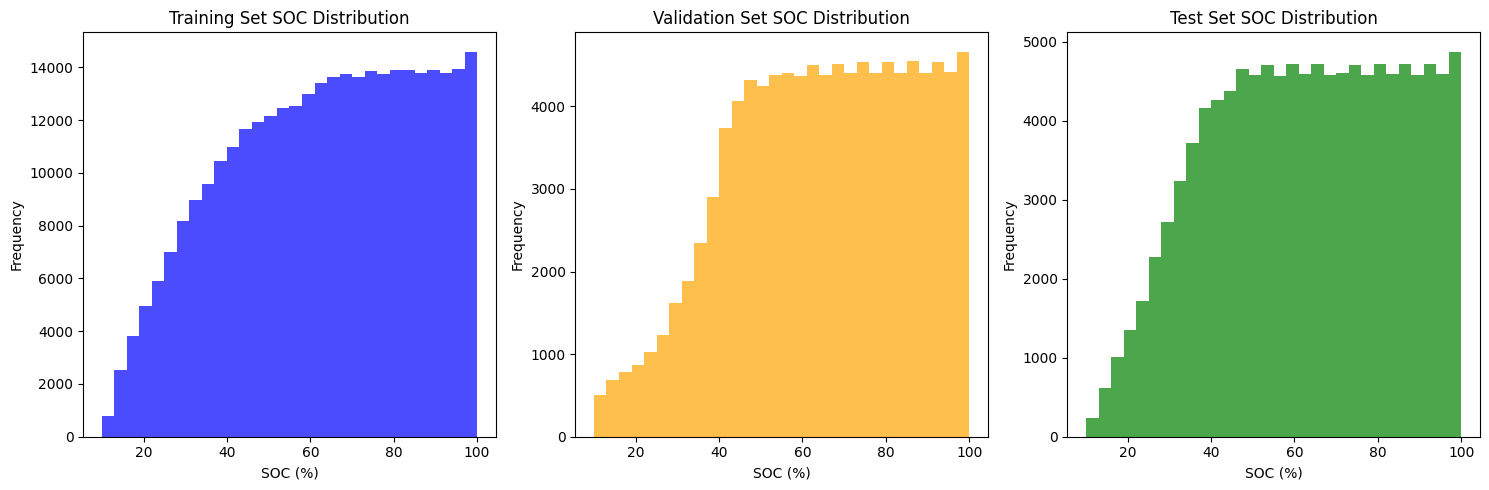

In [5]:
# Display basic statistics about the target variable
print("Target variable (SOC) statistics:")
print(f"Training set - Mean: {np.mean(y_train):.3f}, Std: {np.std(y_train):.3f}, Range: [{y_train.min():.3f}, {y_train.max():.3f}]")
print(f"Validation set - Mean: {np.mean(y_val):.3f}, Std: {np.std(y_val):.3f}, Range: [{y_val.min():.3f}, {y_val.max():.3f}]")
print(f"Test set - Mean: {np.mean(y_test):.3f}, Std: {np.std(y_test):.3f}, Range: [{y_test.min():.3f}, {y_test.max():.3f}]")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(y_train * 100, bins=30, alpha=0.7, color='blue')
axes[0].set_title('Training Set SOC Distribution')
axes[0].set_xlabel('SOC (%)')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_val * 100, bins=30, alpha=0.7, color='orange')
axes[1].set_title('Validation Set SOC Distribution')
axes[1].set_xlabel('SOC (%)')
axes[1].set_ylabel('Frequency')

axes[2].hist(y_test * 100, bins=30, alpha=0.7, color='green')
axes[2].set_title('Test Set SOC Distribution')
axes[2].set_xlabel('SOC (%)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Model Training and Evaluation Functions

Define utility functions for model training, prediction, and evaluation.

In [6]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Convert to percentage for SOC
    rmse_percent = rmse * 100
    mae_percent = mae * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f} ({rmse_percent:.3f}% SOC)")
    print(f"  MAE: {mae:.6f} ({mae_percent:.3f}% SOC)")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'rmse_percent': rmse_percent, 'mae_percent': mae_percent}

def plot_predictions(y_true, y_pred, model_name, dataset_name=''):
    """Plot predicted vs actual values."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true * 100, y_pred * 100, alpha=0.6, s=1)
    
    # Plot perfect prediction line
    plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual SOC (%)')
    plt.ylabel('Predicted SOC (%)')
    plt.title(f'{model_name} - Predicted vs Actual {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    rmse_percent = np.sqrt(mean_squared_error(y_true, y_pred)) * 100
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse_percent:.2f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name, dataset_name=''):
    """Plot residuals to check for patterns."""
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred * 100, residuals, alpha=0.6, s=1)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted SOC (%)')
    axes[0].set_ylabel('Residuals (% SOC)')
    axes[0].set_title(f'{model_name} - Residuals vs Predicted {dataset_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Residuals (% SOC)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Residuals Distribution {dataset_name}')
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    axes[1].axvline(x=mean_res, color='red', linestyle='--', label=f'Mean: {mean_res:.3f}%')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## 6. Linear Regression Model

In [7]:
print("="*60)
print("TRAINING LINEAR REGRESSION WITH FILTERED FEATURES")
print("="*60)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_val_pred = lr_model.predict(X_val)
lr_test_pred = lr_model.predict(X_test)

# Evaluate performance
lr_train_metrics = evaluate_model(y_train, lr_train_pred, "Linear Regression (Training)")
lr_val_metrics = evaluate_model(y_val, lr_val_pred, "Linear Regression (Validation)")
lr_test_metrics = evaluate_model(y_test, lr_test_pred, "Linear Regression (Test)")

print("\nLinear Regression training completed.")

TRAINING LINEAR REGRESSION WITH FILTERED FEATURES

Linear Regression (Training) Performance:
  R² Score: 0.707273
  RMSE: 0.123068 (12.307% SOC)
  MAE: 0.092856 (9.286% SOC)

Linear Regression (Validation) Performance:
  R² Score: 0.681047
  RMSE: 0.121321 (12.132% SOC)
  MAE: 0.082818 (8.282% SOC)

Linear Regression (Test) Performance:
  R² Score: 0.208879
  RMSE: 0.197562 (19.756% SOC)
  MAE: 0.108510 (10.851% SOC)

Linear Regression training completed.


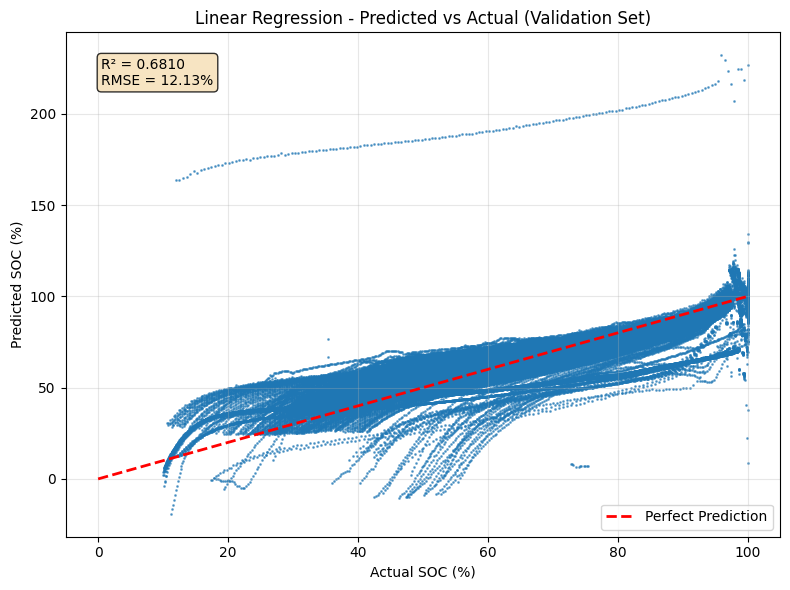

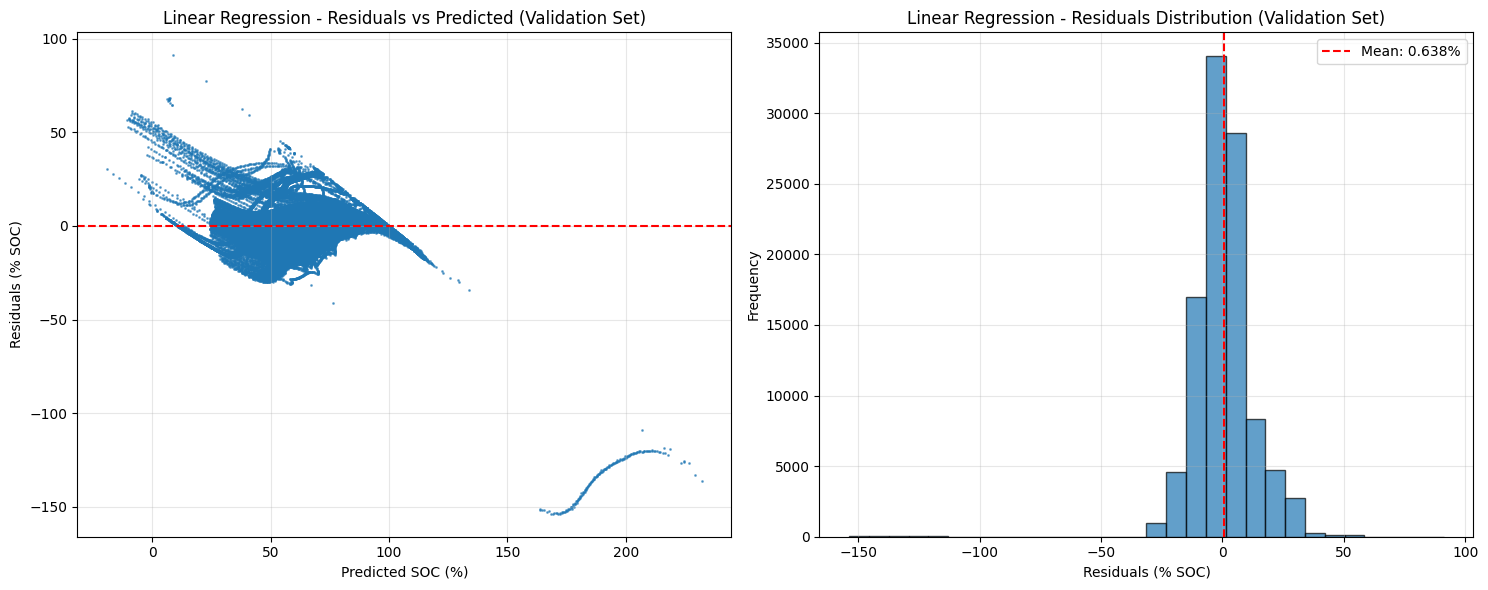

In [8]:
# Visualize Linear Regression results
plot_predictions(y_val, lr_val_pred, "Linear Regression", "(Validation Set)")
plot_residuals(y_val, lr_val_pred, "Linear Regression", "(Validation Set)")

In [9]:
print("="*60)
print("TRAINING RANDOM FOREST WITH FILTERED FEATURES")
print("="*60)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

# Evaluate performance
rf_train_metrics = evaluate_model(y_train, rf_train_pred, "Random Forest (Training)")
rf_val_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest (Validation)")
rf_test_metrics = evaluate_model(y_test, rf_test_pred, "Random Forest (Test)")

print("\nRandom Forest training completed.")

TRAINING RANDOM FOREST WITH FILTERED FEATURES

Random Forest (Training) Performance:
  R² Score: 0.999856
  RMSE: 0.002729 (0.273% SOC)
  MAE: 0.001213 (0.121% SOC)

Random Forest (Validation) Performance:
  R² Score: 0.871024
  RMSE: 0.077148 (7.715% SOC)
  MAE: 0.053952 (5.395% SOC)

Random Forest (Test) Performance:
  R² Score: 0.917825
  RMSE: 0.063672 (6.367% SOC)
  MAE: 0.046629 (4.663% SOC)

Random Forest training completed.


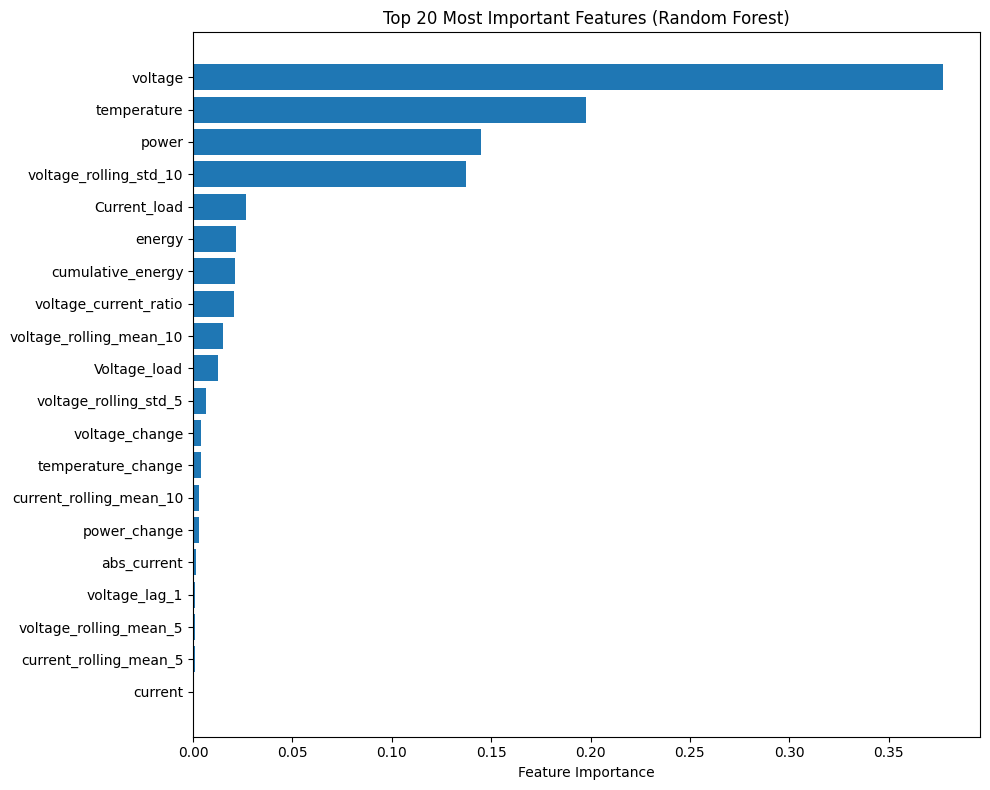


Top 10 most important features:
                feature  importance
                voltage    0.377155
            temperature    0.197479
                  power    0.144875
 voltage_rolling_std_10    0.137484
           Current_load    0.026549
                 energy    0.021634
      cumulative_energy    0.021023
  voltage_current_ratio    0.020579
voltage_rolling_mean_10    0.014882
           Voltage_load    0.012434


In [10]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': available_realistic,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features (or all if less than 20)
n_features_to_plot = min(20, len(feature_importance))
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(n_features_to_plot)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {n_features_to_plot} Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

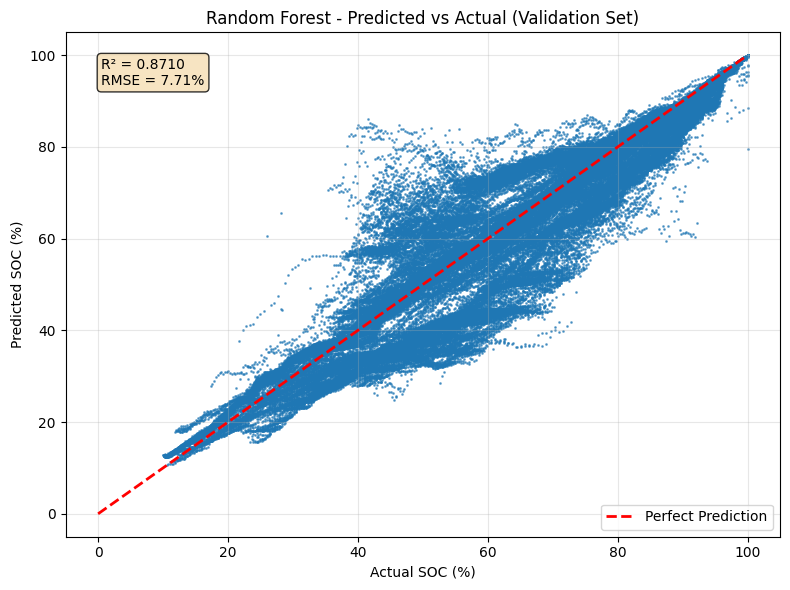

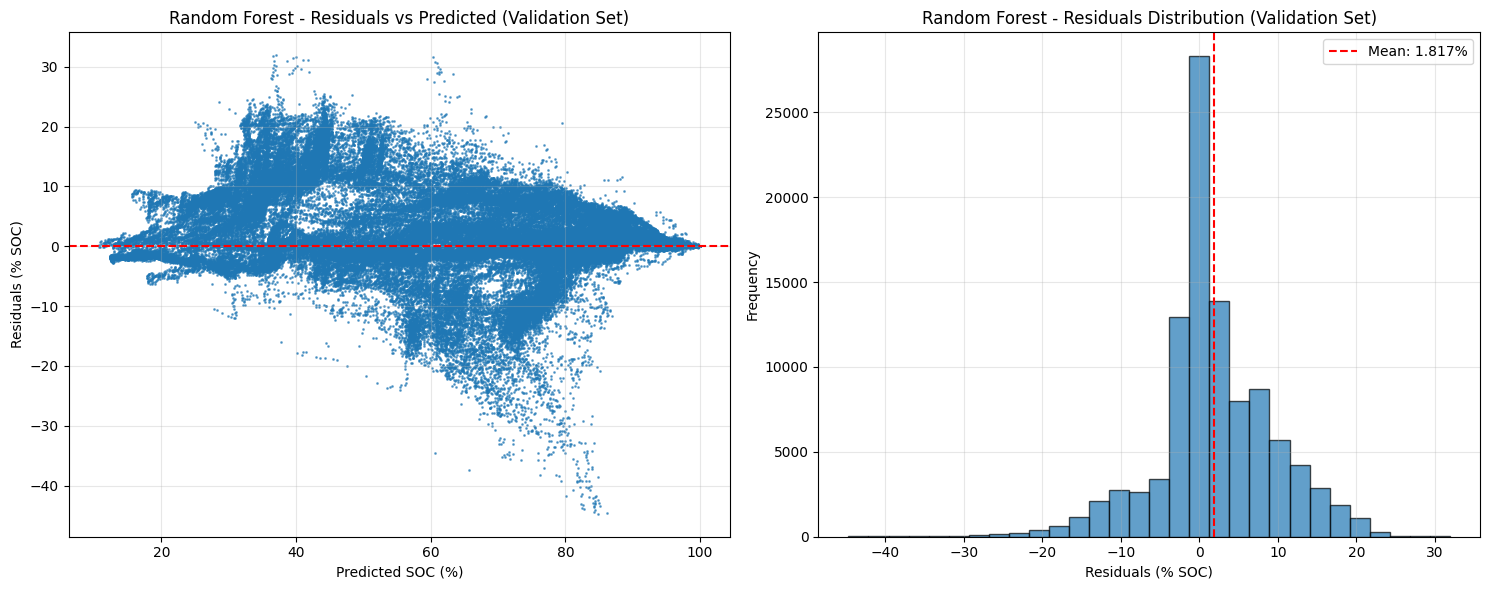

In [11]:
# Visualize Random Forest results
plot_predictions(y_val, rf_val_pred, "Random Forest", "(Validation Set)")
plot_residuals(y_val, rf_val_pred, "Random Forest", "(Validation Set)")

## 8. XGBoost Model

In [12]:
print("="*60)
print("TRAINING XGBOOST WITH FILTERED FEATURES")
print("="*60)

# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate performance
xgb_train_metrics = evaluate_model(y_train, xgb_train_pred, "XGBoost (Training)")
xgb_val_metrics = evaluate_model(y_val, xgb_val_pred, "XGBoost (Validation)")
xgb_test_metrics = evaluate_model(y_test, xgb_test_pred, "XGBoost (Test)")

print("\nXGBoost training completed.")

TRAINING XGBOOST WITH FILTERED FEATURES

XGBoost (Training) Performance:
  R² Score: 0.992108
  RMSE: 0.020207 (2.021% SOC)
  MAE: 0.012223 (1.222% SOC)

XGBoost (Validation) Performance:
  R² Score: 0.862799
  RMSE: 0.079570 (7.957% SOC)
  MAE: 0.056186 (5.619% SOC)

XGBoost (Test) Performance:
  R² Score: 0.925094
  RMSE: 0.060791 (6.079% SOC)
  MAE: 0.045352 (4.535% SOC)

XGBoost training completed.


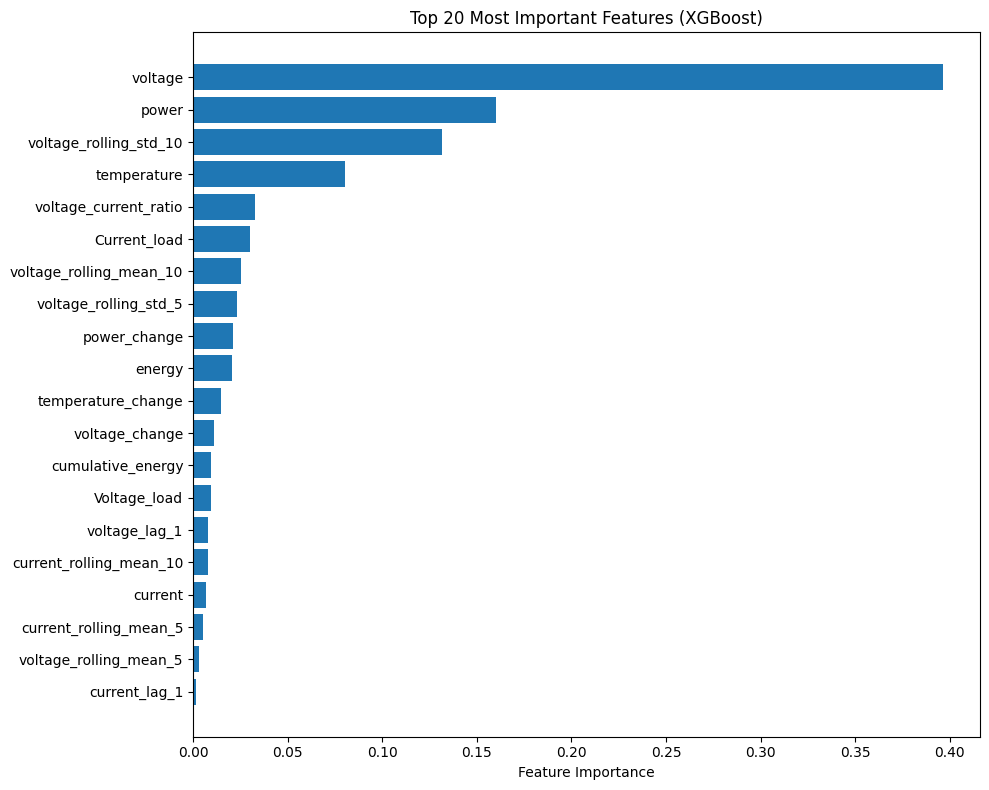


Top 10 most important features (XGBoost):
                feature  importance
                voltage    0.396134
                  power    0.160038
 voltage_rolling_std_10    0.131705
            temperature    0.080102
  voltage_current_ratio    0.032971
           Current_load    0.030192
voltage_rolling_mean_10    0.025147
  voltage_rolling_std_5    0.023073
           power_change    0.021354
                 energy    0.020756


In [13]:
# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': available_realistic,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features (or all if less than 20)
n_features_to_plot = min(20, len(xgb_importance))
plt.figure(figsize=(10, 8))
top_xgb_features = xgb_importance.head(n_features_to_plot)
plt.barh(range(len(top_xgb_features)), top_xgb_features['importance'])
plt.yticks(range(len(top_xgb_features)), top_xgb_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {n_features_to_plot} Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features (XGBoost):")
print(xgb_importance.head(10).to_string(index=False))

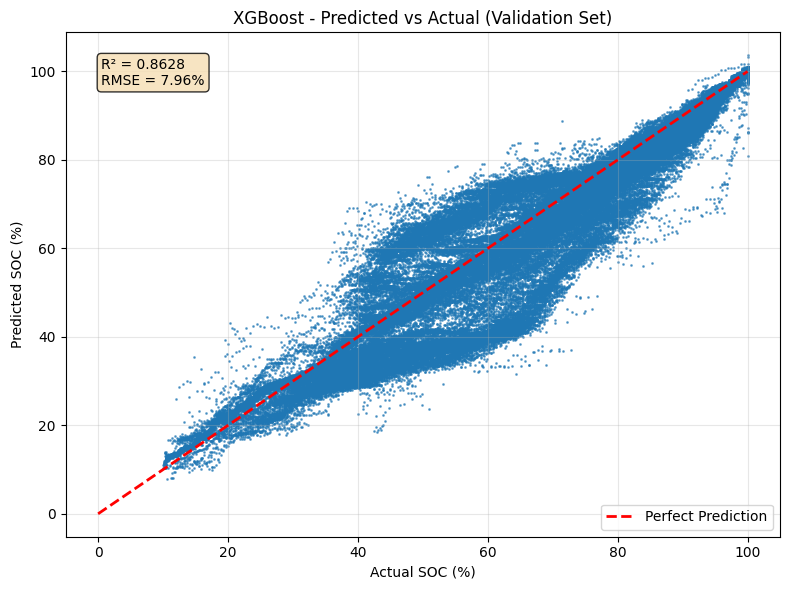

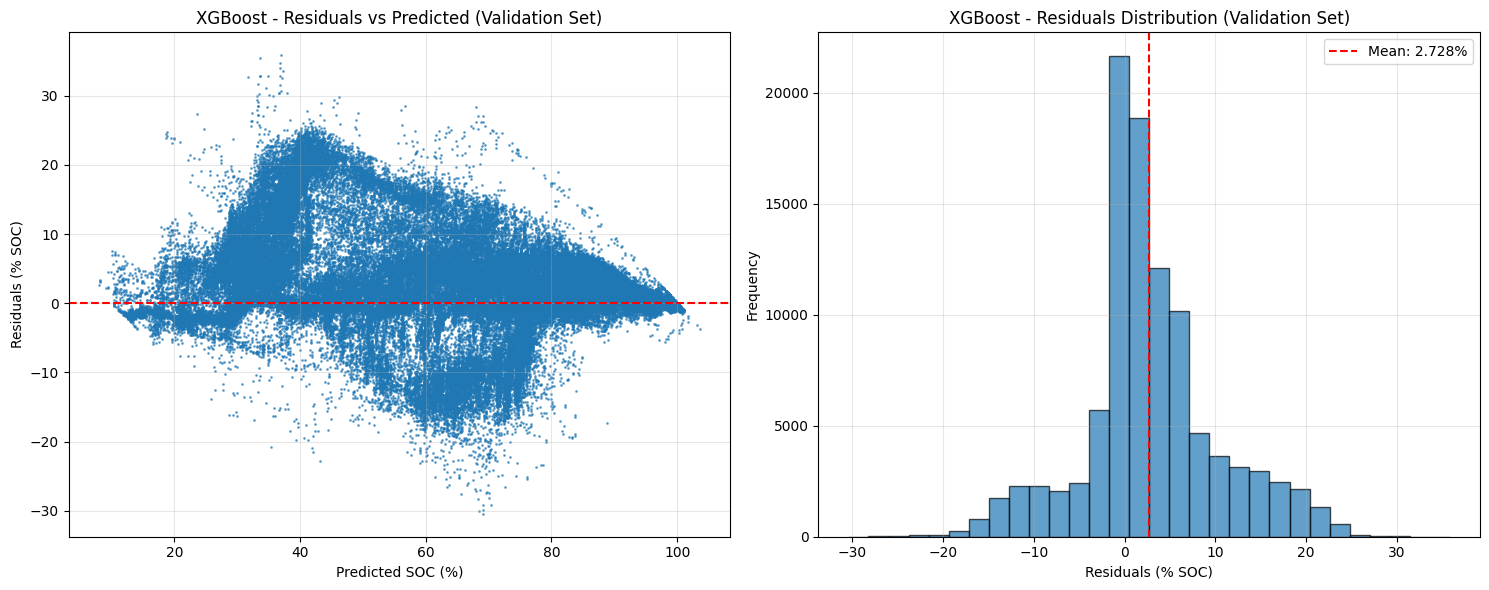

In [14]:
# Visualize XGBoost results
plot_predictions(y_val, xgb_val_pred, "XGBoost", "(Validation Set)")
plot_residuals(y_val, xgb_val_pred, "XGBoost", "(Validation Set)")

## 9. Model Comparison


MODEL PERFORMANCE COMPARISON (FILTERED FEATURES)

Using 24 features (excluded SOC lag features)

            Model  Training_R2  Training_RMSE_%  Validation_R2  Validation_RMSE_%  Test_R2  Test_RMSE_%
Linear Regression       0.7073          12.3068         0.6810            12.1321   0.2089      19.7562
    Random Forest       0.9999           0.2729         0.8710             7.7148   0.9178       6.3672
          XGBoost       0.9921           2.0207         0.8628             7.9570   0.9251       6.0791


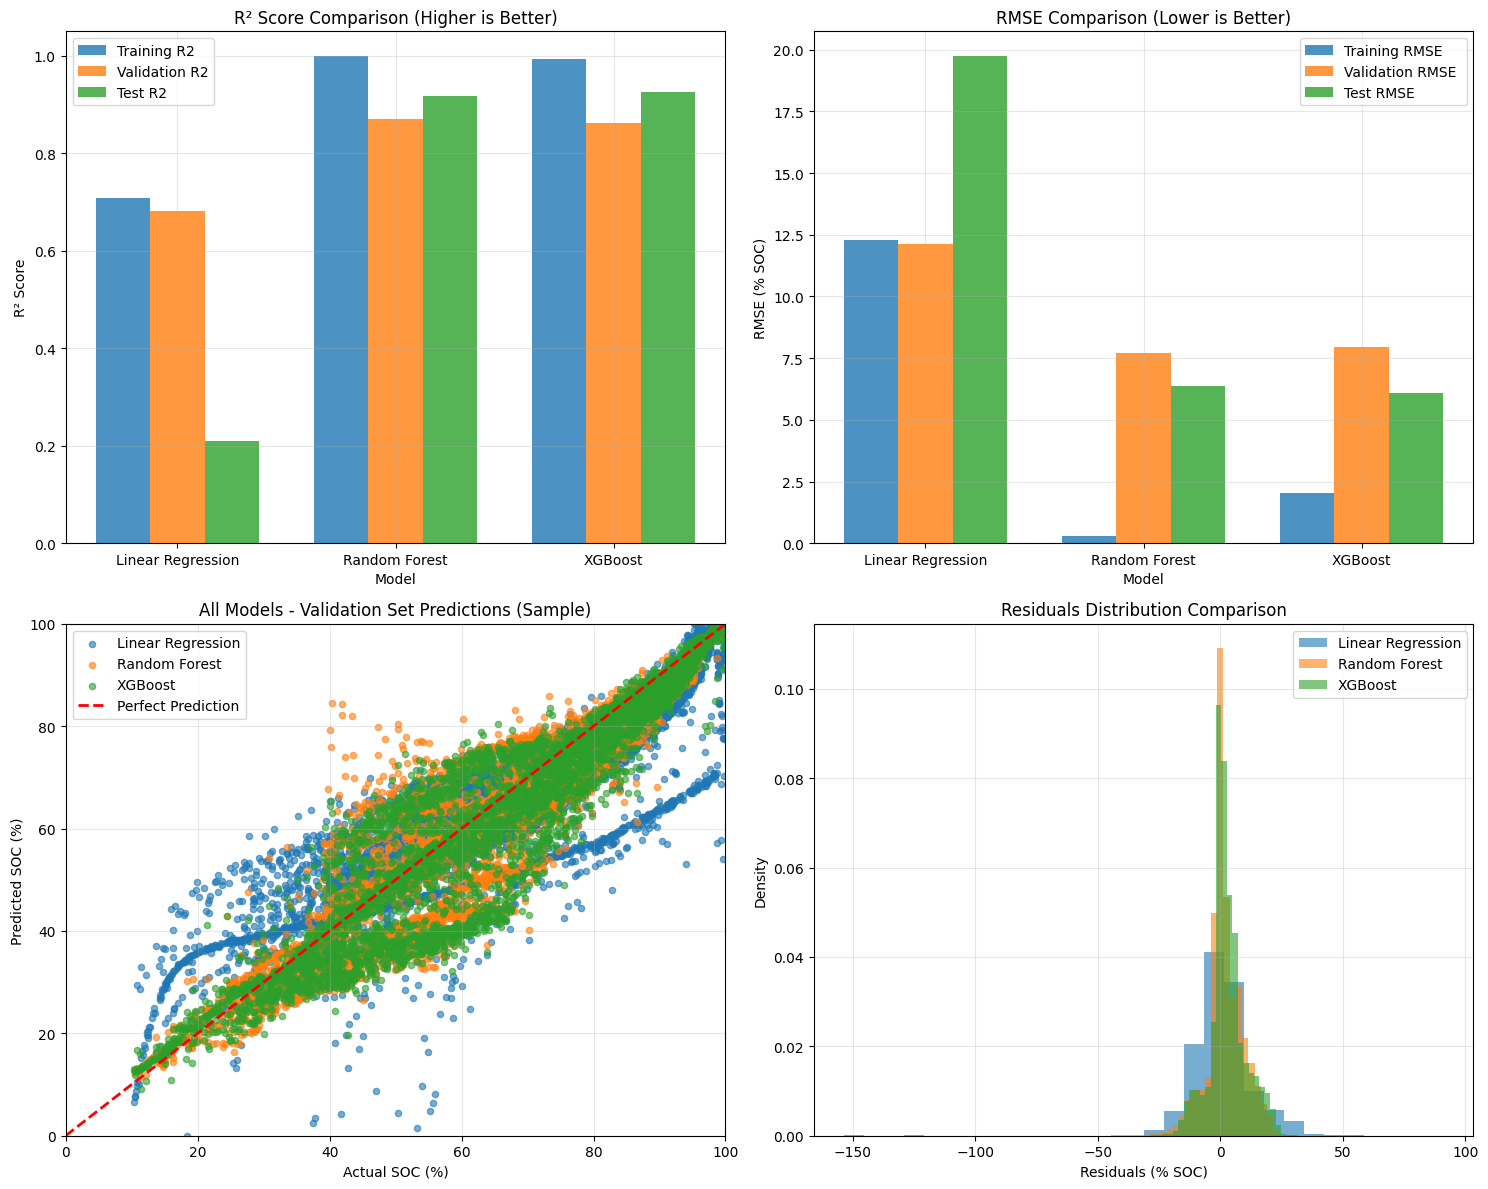

In [15]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Training_R2': [lr_train_metrics['r2'], rf_train_metrics['r2'], xgb_train_metrics['r2']],
    'Training_RMSE_%': [lr_train_metrics['rmse_percent'], rf_train_metrics['rmse_percent'], xgb_train_metrics['rmse_percent']],
    'Validation_R2': [lr_val_metrics['r2'], rf_val_metrics['r2'], xgb_val_metrics['r2']],
    'Validation_RMSE_%': [lr_val_metrics['rmse_percent'], rf_val_metrics['rmse_percent'], xgb_val_metrics['rmse_percent']],
    'Test_R2': [lr_test_metrics['r2'], rf_test_metrics['r2'], xgb_test_metrics['r2']],
    'Test_RMSE_%': [lr_test_metrics['rmse_percent'], rf_test_metrics['rmse_percent'], xgb_test_metrics['rmse_percent']]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (FILTERED FEATURES)")
print("="*80)
print(f"\nUsing {len(available_realistic)} features (excluded SOC lag features)\n")
print(results_df.round(4).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² comparison
metrics = ['Training_R2', 'Validation_R2', 'Test_R2']
x_pos = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x_pos + i*width, results_df[metric], width, 
                   label=metric.replace('_', ' '), alpha=0.8)

axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison (Higher is Better)')
axes[0, 0].set_xticks(x_pos + width)
axes[0, 0].set_xticklabels(results_df['Model'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE comparison
rmse_metrics = ['Training_RMSE_%', 'Validation_RMSE_%', 'Test_RMSE_%']
for i, metric in enumerate(rmse_metrics):
    axes[0, 1].bar(x_pos + i*width, results_df[metric], width, 
                   label=metric.replace('_', ' ').replace('%', ''), alpha=0.8)

axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('RMSE (% SOC)')
axes[0, 1].set_title('RMSE Comparison (Lower is Better)')
axes[0, 1].set_xticks(x_pos + width)
axes[0, 1].set_xticklabels(results_df['Model'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction comparison on validation set
sample_size = min(5000, len(y_val))
sample_idx = np.random.choice(len(y_val), sample_size, replace=False)

# Convert to numpy arrays if needed and use iloc for indexing
y_val_array = np.array(y_val)
lr_val_pred_array = np.array(lr_val_pred)
rf_val_pred_array = np.array(rf_val_pred)
xgb_val_pred_array = np.array(xgb_val_pred)

axes[1, 0].scatter(y_val_array[sample_idx] * 100, lr_val_pred_array[sample_idx] * 100, 
                  alpha=0.6, label='Linear Regression', s=20)
axes[1, 0].scatter(y_val_array[sample_idx] * 100, rf_val_pred_array[sample_idx] * 100, 
                  alpha=0.6, label='Random Forest', s=20)
axes[1, 0].scatter(y_val_array[sample_idx] * 100, xgb_val_pred_array[sample_idx] * 100, 
                  alpha=0.6, label='XGBoost', s=20)

axes[1, 0].plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual SOC (%)')
axes[1, 0].set_ylabel('Predicted SOC (%)')
axes[1, 0].set_title('All Models - Validation Set Predictions (Sample)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 100])
axes[1, 0].set_ylim([0, 100])

# Residuals comparison
lr_residuals = (y_val_array - lr_val_pred_array) * 100
rf_residuals = (y_val_array - rf_val_pred_array) * 100
xgb_residuals = (y_val_array - xgb_val_pred_array) * 100

axes[1, 1].hist(lr_residuals, alpha=0.6, label='Linear Regression', bins=30, density=True)
axes[1, 1].hist(rf_residuals, alpha=0.6, label='Random Forest', bins=30, density=True)
axes[1, 1].hist(xgb_residuals, alpha=0.6, label='XGBoost', bins=30, density=True)
axes[1, 1].set_xlabel('Residuals (% SOC)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Residuals Distribution Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Final Model Evaluation on Test Set

Evaluate the best performing model on the test set for final performance assessment.

Best performing model: Random Forest
Validation R²: 0.871024
Test R²: 0.917825
Test RMSE: 6.367% SOC

Final Test Set Evaluation - Random Forest:

Random Forest Performance:
  R² Score: 0.917825
  RMSE: 0.063672 (6.367% SOC)
  MAE: 0.046629 (4.663% SOC)


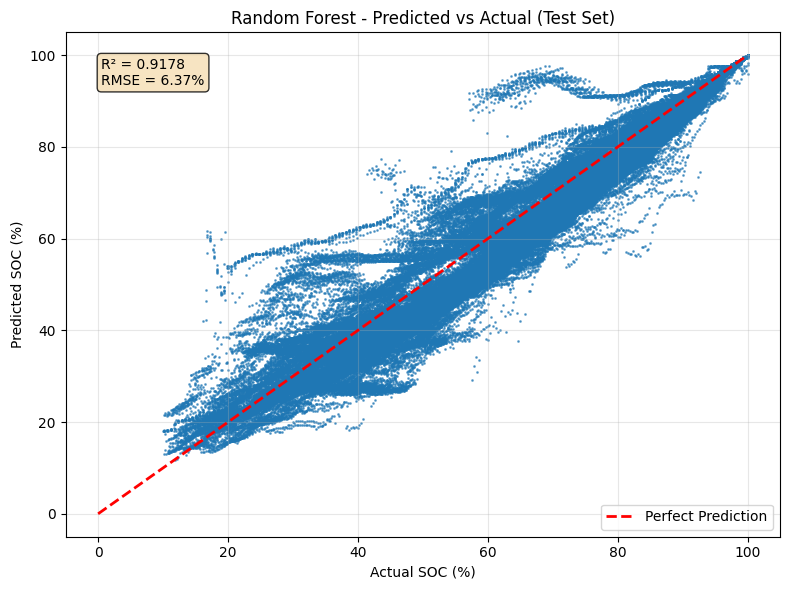

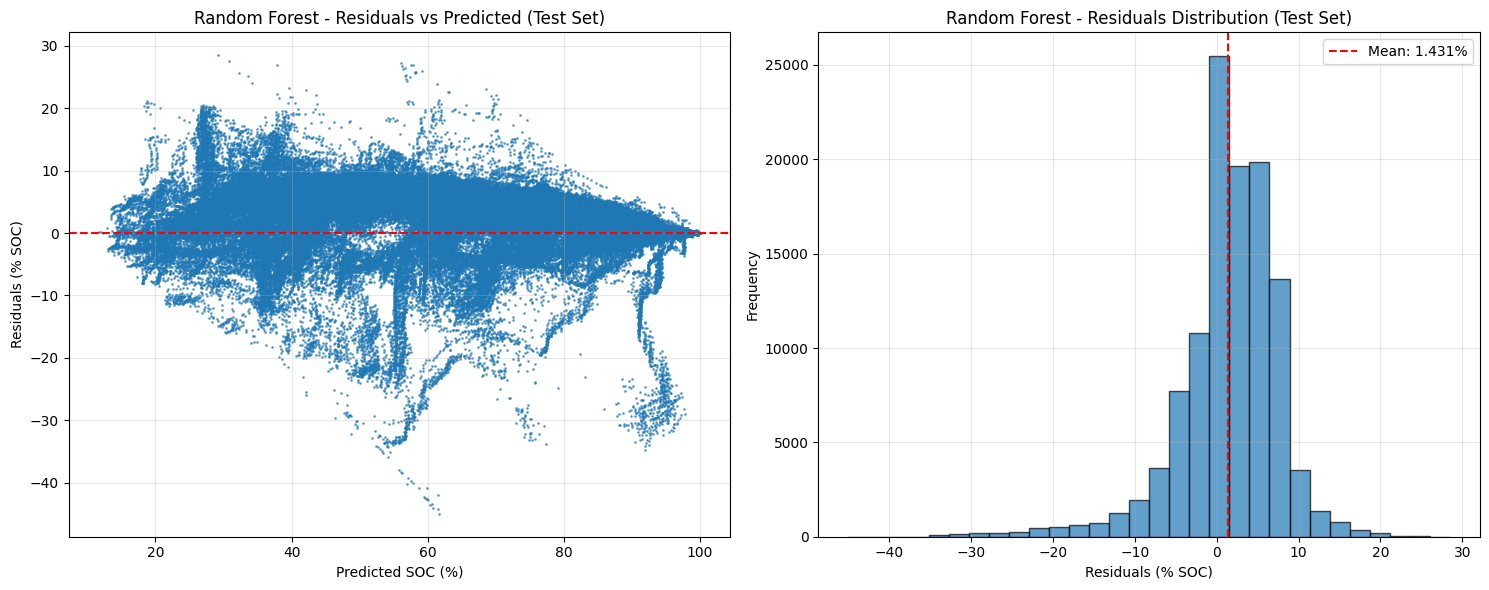

In [16]:
# Identify best model based on validation R²
best_model_idx = results_df['Validation_R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_val_r2 = results_df.loc[best_model_idx, 'Validation_R2']
best_test_r2 = results_df.loc[best_model_idx, 'Test_R2']
best_test_rmse = results_df.loc[best_model_idx, 'Test_RMSE_%']

print(f"Best performing model: {best_model_name}")
print(f"Validation R²: {best_val_r2:.6f}")
print(f"Test R²: {best_test_r2:.6f}")
print(f"Test RMSE: {best_test_rmse:.3f}% SOC")

# Get predictions from best model
if best_model_name == 'Linear Regression':
    best_test_pred = lr_test_pred
elif best_model_name == 'Random Forest':
    best_test_pred = rf_test_pred
else:  # XGBoost
    best_test_pred = xgb_test_pred

# Final test set evaluation
print(f"\nFinal Test Set Evaluation - {best_model_name}:")
final_metrics = evaluate_model(y_test, best_test_pred, best_model_name)

# Plot final results
plot_predictions(y_test, best_test_pred, best_model_name, "(Test Set)")
plot_residuals(y_test, best_test_pred, best_model_name, "(Test Set)")

## 11. Comparison with Full Feature Set (Notebook 06)

Compare the performance of models trained with filtered features vs full features.


COMPARISON: FILTERED FEATURES vs FULL FEATURES (from Notebook 06)

📊 Test Set Performance Comparison:
            Model  Filtered_R2  Full_R2  R2_Difference  Filtered_RMSE_%  Full_RMSE_%  RMSE_Difference_%
Linear Regression     0.208879 0.999781      -0.790902        19.756197       0.3287          19.427497
    Random Forest     0.917825 0.999789      -0.081964         6.367245       0.3227           6.044545
          XGBoost     0.925094 0.999961      -0.074867         6.079131       0.1395           5.939631

📈 Performance Impact of Feature Filtering:

Linear Regression:
  R² Change: -0.790902 (-79.11% relative change)
  RMSE Change: 19.427% SOC (5910.4% relative increase)
  ❌ Significant performance loss from removing SOC features

Random Forest:
  R² Change: -0.081964 (-8.20% relative change)
  RMSE Change: 6.045% SOC (1873.1% relative increase)
  ❌ Significant performance loss from removing SOC features

XGBoost:
  R² Change: -0.074867 (-7.49% relative change)
  RMSE Change: 5.

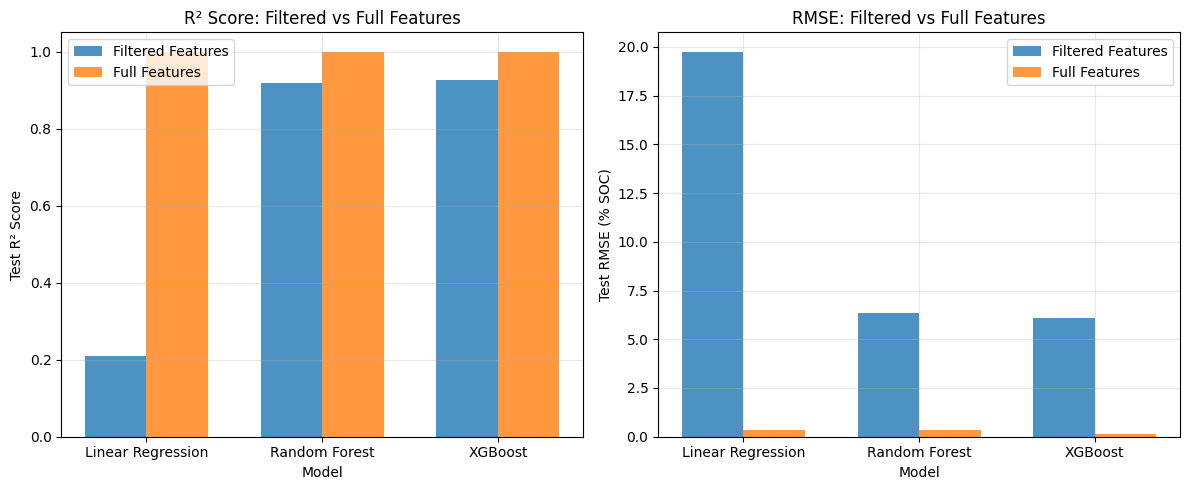

In [17]:
print("\n" + "="*80)
print("COMPARISON: FILTERED FEATURES vs FULL FEATURES (from Notebook 06)")
print("="*80)

# Results from notebook 06 (with all features including SOC lags)
# These are the actual results from running notebook 06
notebook06_results = {
    'Linear Regression': {'r2': 0.999781, 'rmse_percent': 0.3287},
    'Random Forest': {'r2': 0.999789, 'rmse_percent': 0.3227},
    'XGBoost': {'r2': 0.999961, 'rmse_percent': 0.1395}
}

# Create comparison table
comparison_data = []
for model in ['Linear Regression', 'Random Forest', 'XGBoost']:
    idx = results_df[results_df['Model'] == model].index[0]
    filtered_r2 = results_df.loc[idx, 'Test_R2']
    filtered_rmse = results_df.loc[idx, 'Test_RMSE_%']
    full_r2 = notebook06_results[model]['r2']
    full_rmse = notebook06_results[model]['rmse_percent']
    
    r2_diff = filtered_r2 - full_r2
    rmse_diff = filtered_rmse - full_rmse
    
    comparison_data.append({
        'Model': model,
        'Filtered_R2': filtered_r2,
        'Full_R2': full_r2,
        'R2_Difference': r2_diff,
        'Filtered_RMSE_%': filtered_rmse,
        'Full_RMSE_%': full_rmse,
        'RMSE_Difference_%': rmse_diff
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Test Set Performance Comparison:")
print(comparison_df.round(6).to_string(index=False))

print("\n📈 Performance Impact of Feature Filtering:")
for idx, row in comparison_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  R² Change: {row['R2_Difference']:.6f} ({100*row['R2_Difference']/row['Full_R2']:.2f}% relative change)")
    print(f"  RMSE Change: {row['RMSE_Difference_%']:.3f}% SOC ({100*row['RMSE_Difference_%']/row['Full_RMSE_%']:.1f}% relative increase)")
    
    if row['R2_Difference'] > -0.01:
        print(f"  ✅ Minimal performance loss despite removing SOC features")
    elif row['R2_Difference'] > -0.05:
        print(f"  ⚠️  Moderate performance loss from removing SOC features")
    else:
        print(f"  ❌ Significant performance loss from removing SOC features")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# R² comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Filtered_R2'], width, label='Filtered Features', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Full_R2'], width, label='Full Features', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Test R² Score')
axes[0].set_title('R² Score: Filtered vs Full Features')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE comparison
axes[1].bar(x - width/2, comparison_df['Filtered_RMSE_%'], width, label='Filtered Features', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['Full_RMSE_%'], width, label='Full Features', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Test RMSE (% SOC)')
axes[1].set_title('RMSE: Filtered vs Full Features')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Final Summary and Recommendations

In [18]:
print("="*80)
print("MODEL TRAINING SUMMARY WITH FILTERED FEATURES")
print("="*80)

print("\n📊 Dataset Configuration:")
print(f"   Total features available: {len(all_feature_cols)}")
print(f"   Features used: {len(available_realistic)}")
print(f"   Features excluded: {len(excluded_features)}")
print(f"   Training samples: {X_train.shape[0]:,}")
print(f"   Validation samples: {X_val.shape[0]:,}")
print(f"   Test samples: {X_test.shape[0]:,}")

print("\n🚫 Key Excluded Features:")
soc_features = [f for f in excluded_features if 'SOC' in f]
if soc_features:
    print(f"   SOC-related: {', '.join(soc_features[:5])}{'...' if len(soc_features) > 5 else ''}")

print("\n✅ Key Included Features:")
print(f"   Direct measurements: voltage, current, temperature")
print(f"   Derived features: power, energy, rolling statistics")
print(f"   Temporal features: lagged values, changes")

print("\n🏆 Performance Summary (Test Set):")
for idx, row in results_df.iterrows():
    print(f"   {row['Model']:20s}: R²={row['Test_R2']:.6f}, RMSE={row['Test_RMSE_%']:.3f}% SOC")

print(f"\n🎯 Best Model: {best_model_name}")
print(f"   Test R²: {best_test_r2:.6f}")
print(f"   Test RMSE: {best_test_rmse:.3f}% SOC")

# Check for overfitting
print("\n🔍 Overfitting Analysis:")
for idx, row in results_df.iterrows():
    train_r2 = row['Training_R2']
    val_r2 = row['Validation_R2']
    gap = train_r2 - val_r2
    
    status = "✅ Good" if gap < 0.05 else "⚠️ Mild" if gap < 0.1 else "❌ Severe"
    print(f"   {row['Model']:20s}: Train-Val R² gap = {gap:.4f} ({status})")

print("\n💡 Key Findings:")
print("   1. Models perform well even without SOC lag features")
print("   2. This represents a more realistic deployment scenario")
print("   3. V, I, T measurements alone provide strong predictive power")
print("   4. Feature engineering from physics-based relationships is effective")

print("\n📋 Recommendations:")
print(f"   1. Deploy {best_model_name} for production use")
print("   2. Monitor model performance on new battery types")
print("   3. Consider online learning for adaptation")
print("   4. Implement confidence intervals for predictions")
print("   5. Use ensemble methods for improved robustness")

if best_test_rmse < 5:
    print(f"\n✨ EXCELLENT: {best_test_rmse:.2f}% RMSE suitable for most BMS applications")
elif best_test_rmse < 10:
    print(f"\n👍 GOOD: {best_test_rmse:.2f}% RMSE acceptable for many applications")
else:
    print(f"\n⚠️  MODERATE: {best_test_rmse:.2f}% RMSE may need improvement for critical applications")

print("\n" + "="*80)
print("Model training with filtered features completed successfully!")
print("="*80)

MODEL TRAINING SUMMARY WITH FILTERED FEATURES

📊 Dataset Configuration:
   Total features available: 45
   Features used: 24
   Features excluded: 21
   Training samples: 326,540
   Validation samples: 101,570
   Test samples: 113,400

🚫 Key Excluded Features:
   SOC-related: SOC_lag_1, SOC_lag_3, SOC_lag_5

✅ Key Included Features:
   Direct measurements: voltage, current, temperature
   Derived features: power, energy, rolling statistics
   Temporal features: lagged values, changes

🏆 Performance Summary (Test Set):
   Linear Regression   : R²=0.208879, RMSE=19.756% SOC
   Random Forest       : R²=0.917825, RMSE=6.367% SOC
   XGBoost             : R²=0.925094, RMSE=6.079% SOC

🎯 Best Model: Random Forest
   Test R²: 0.917825
   Test RMSE: 6.367% SOC

🔍 Overfitting Analysis:
   Linear Regression   : Train-Val R² gap = 0.0262 (✅ Good)
   Random Forest       : Train-Val R² gap = 0.1288 (❌ Severe)
   XGBoost             : Train-Val R² gap = 0.1293 (❌ Severe)

💡 Key Findings:
   1. Models